In [1]:
# Requirements: Python 3.x, TensorFlow 2.x

from absl import logging
import tensorflow as tf
import matplotlib.pyplot as plt

# When executing this notebook out of a subfolder, use the command below to
# change to the project's root folder (required for imports):
# %cd ..

from tqdm import tqdm
from itertools import cycle
from model import build_model

In [2]:
# Hyperparameters.
batch_size = 8
num_slots = 7
num_iterations = 3
ckpt_path = "training"  # Path to model checkpoint.

In [3]:
def load_model(checkpoint_dir, num_slots=7, num_iterations=5, batch_size=8):
    resolution = (256,256)
    model = build_model(resolution, batch_size, num_slots, num_iterations)

    ckpt = tf.train.Checkpoint(network=model)
    ckpt_manager = tf.train.CheckpointManager(ckpt, directory=checkpoint_dir, max_to_keep=5)

    if ckpt_manager.latest_checkpoint:
        status = ckpt.restore(ckpt_manager.latest_checkpoint)
        status.expect_partial()
        print(f"Restored from {ckpt_manager.latest_checkpoint}")
        logging.info("Restored from %s", ckpt_manager.latest_checkpoint)

    return model

In [4]:
# Build dataset iterators, optimizers and model.
from data_utils import allen_cell_dataset

train_iterator, test_iterator, val_iterator = allen_cell_dataset(False, batch_size)
train_iterator = cycle(list(train_iterator))
test_iterator = cycle(list(test_iterator))
val_iterator = cycle(list(val_iterator))

loading data:   0%|                                                                                                                                                                                                      | 0/49325 [00:00<?, ?it/s]2022-12-14 23:12:35.843331: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 23:12:35.878872: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
loading data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [5]:
model = load_model(ckpt_path)

Restored from training/cp-1000.ckpt


In [6]:
def renormalize(x):
  """Renormalize from [0.0, 255.0] to [0.0, 1.0]."""
  return x / 255

def get_prediction(model, batch, idx=0):
  recon_combined, recons, masks, slots = model(batch)
  image = renormalize(batch)[idx]
  recon_combined = recon_combined[idx]
  recons = recons[idx]
  masks = masks[idx]
  return image, recon_combined, recons, masks, slots

In [7]:
# Get new batch.
batch = next(val_iterator)

In [8]:
# Predict.
image, recon_combined, recons, masks, slots = get_prediction(model, batch)

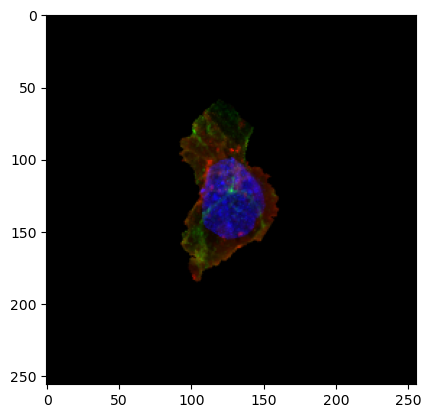

In [9]:
plt.imshow(image)

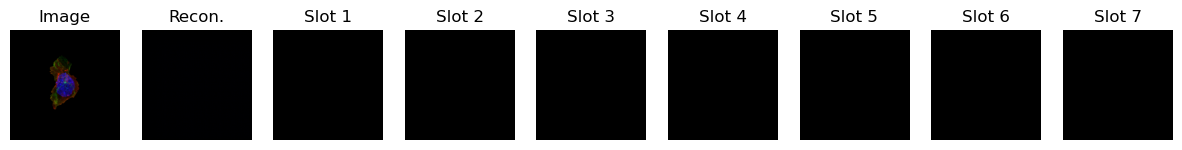

In [10]:
# Visualize.
num_slots = len(masks)
fig, ax = plt.subplots(1, num_slots + 2, figsize=(15, 2))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(recon_combined)
ax[1].set_title('Recon.')
for i in range(num_slots):
  #ax[i + 2].imshow(recons[i] * masks[i] + (1 - masks[i]))
  ax[i + 2].imshow(tf.zeros(recons[i].shape))
  ax[i + 2].set_title('Slot %s' % str(i + 1))
for i in range(len(ax)):
  ax[i].grid(False)
  ax[i].axis('off')

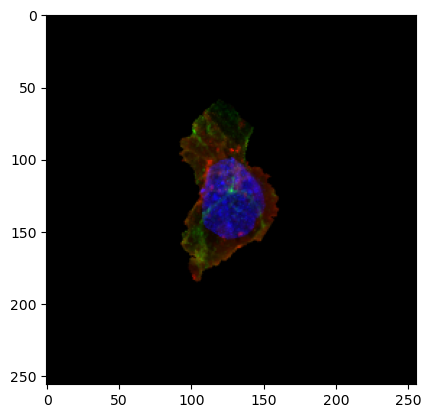

In [11]:
plt.imshow(image)